# Boosting trees

An XGboost model with shapely values for explanations.



In [1]:
import pandas as pd
from time import time
import os
import json
import numpy as np 
from time import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="white")

import shap
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# load JS visualization code to notebook
shap.initjs()

# Fetch the data

In [3]:
start_time = time()
with open("configuration.json", 'rt') as infile:
    config = json.load(infile)

S = ['target', 'UN', 'UNHCR', 'worldbank', 'ACLED', 'UN', 'WHO', 'HumanRights', 'SystemicPeace']

sources = [os.path.join(config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources'] if (d['name'] in S)]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Row count          : {}".format(len(df)))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))

Sources            : 8
Row count          : 360486
Geographies        : 316
Indicators         : 67
Temporal coverage  : 1946 -> 2018
Null values        : 209

Loaded data in 0.69 sec.


In [4]:
df['Indicator Code'].unique()

array(['ETH.TO.SAU', 'ETH.TO.ITA', 'ETH.TO.GBR', 'ETH.TO.DNK',
       'ETH.TO.SWE', 'ETH.TO.ZAF', 'SP.DYN.TFRT.IN', 'SP.POP.TOTL',
       'SP.RUR.TOTL', 'SP.URB.TOTL', 'SP.URB.GROW', 'IT.NET.USER.ZS',
       'AG.PRD.FOOD.XD', 'AG.PRD.LVSK.XD', 'EN.POP.DNST',
       'ER.H2O.INTR.PC', 'ER.GDP.FWTL.M3.KD', 'SE.ADT.LITR.ZS',
       'SI.POV.GINI', 'VC.BTL.DETH', 'EG.ELC.ACCS.ZS',
       'NY.GDP.PCAP.PP.CD', 'EN.ATM.PM25.MC.M3', 'IQ.CPA.PROP.XQ',
       'UNHCR.OUT.REF', 'UNHCR.OUT.RET', 'UNHCR.OUT.IDP',
       'UNHCR.OUT.RETIDP', 'UNHCR.OUT.OOC', 'UNHCR.OUT.AS',
       'UNHCR.OUT.STLS', 'ACLED.COUNT', 'ACLED.FATALITIES', 'UN.TOTL.POP',
       'UN.TOTL.POP_MALE', 'UN.TOTL.POP_FEMALE', 'UN.POP.GROWTH.RATE',
       'WHO.MAT.MORT.RATIO', 'WHO.MAT.DEATHS', 'WHO.TB.TMT.COV',
       'WHO.NUM.TB.CAS', 'WHO.TB.CAS', 'WHO.UND.FIV.DTH', 'WHO.INF.DTH',
       'WHO.NEO.DTH', 'WHO.EXT.HTLTH.EXP', 'WHO.OOP.HLTH.EXP',
       'HR.SCR.MEAN', 'HR.SCR.SD', 'SP.FDP.REFG.ORIG', 'SP.FDP.IDP',
       'SP.FDP.REFG.H

In [5]:
df.loc[df.value.isnull(), 'Indicator Code'].unique()

array(['WHO.MAT.DEATHS', 'WHO.TB.TMT.COV', 'WHO.TB.CAS'], dtype=object)

## Data transformations

Since data for Ethiopia alone is sparse, we evaluate a subset of countries (Sub-Saharan countries) and include indicator variables for these.

In [6]:
# Sub-Saharan countries codes
SSA = ['BDI', 'COM', 'DJI', 'ERI', 'ETH', 'ATF', 'KEN', 'MDG', 'MWI', 
       'MUS', 'MYT', 'MOZ', 'REU', 'RWA', 'SYC', 'SOM', 'SSD', 'TZA', 
       'UGA', 'ZMB', 'ZWE']

print("All data: {} rows.".format(len(df)))
c1 = df['Country Code'].isin(SSA)

df = df[c1]

print("Sub-Saharan data: {} rows.".format(len(df)))
print("Sub-Saharan indicators: {}.".format(len(df['Indicator Code'].unique())))

# Organize the indicators in "long form"
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

# Generate one hot encodings of the country labels
tmp = pd.get_dummies(data['Country Code'])
data = pd.concat([data, tmp], axis=1)
data.drop(columns=['Country Code'], inplace=True)

print("Data frame of size %u (rows), %u (columns)" % data.shape)


All data: 360486 rows.
Sub-Saharan data: 23454 rows.
Sub-Saharan indicators: 47.
Data frame of size 1374 (rows), 68 (columns)


In [7]:
data.head()

,year,ACLED.COUNT,ACLED.FATALITIES,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,EG.ELC.ACCS.ZS,EN.ATM.PM25.MC.M3,EN.POP.DNST,ER.GDP.FWTL.M3.KD,ER.H2O.INTR.PC,...,MYT,REU,RWA,SOM,SSD,SYC,TZA,UGA,ZMB,ZWE
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


## Data plots

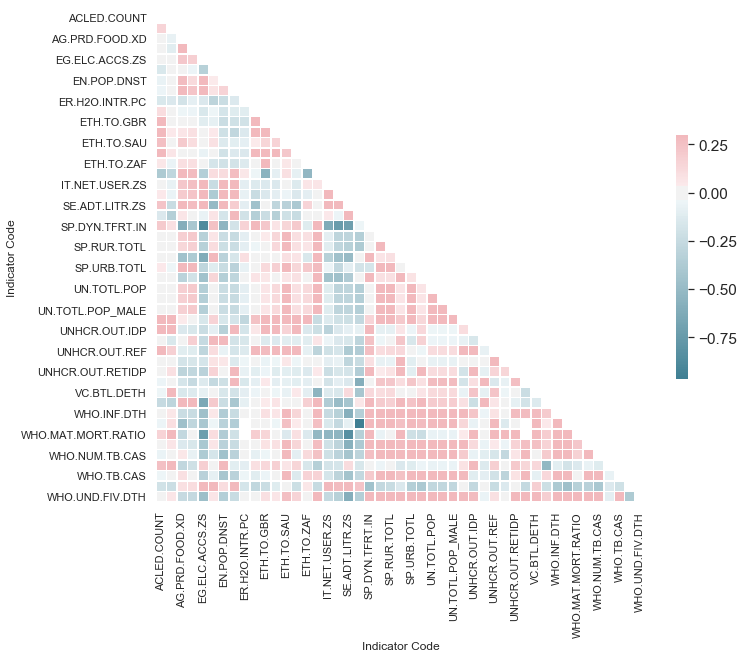

In [8]:
# Compute the correlation matrix
# Organize the indicators in "long form"
d = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(font_scale=1.4)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.savefig("correlation.png", dpi=200, bbox_inches='tight')

# Model

We set up a model based on data for $n$ number of years and create a forecast for $n+1$th year. No temporal lag features or projections are considered yet. 

In [24]:
def model_data(data, training_years, forecast_year, target_var, filter_var):
    """ 
    Generate a model instance for training/forecast
    
    data: dataframe with the Sub-Saharan data
    training_years: Tuple showing min-max years, e.g. (1995, 2010)
    forecast_year: test year, (2011)
    target_var: variable name to forecast e.g. 'ETH.TO.GBR'
    filter_var: list of variables NOT to consider
    
    returns: 
        training, test matrices.
    """
    
    min_year, max_year = training_years
    tidx = data.year.between(*training_years)
    vidx = (data.year == forecast_year) & (data.ETH == 1)
    x_cols = list(set(data.columns.values) - set(filter_var))

    # Remove nulls from the target variable 
    c1 = ~pd.isnull(data[target_var])
    data = data[c1]
    
    # Training data
    Xt = data.loc[tidx, x_cols]
    yt = data.loc[tidx, target_var]
    
    # Forecast/validation data
    Xv = data.loc[vidx, x_cols]
    yv = data.loc[vidx, target_var]
    
    dt = xgb.DMatrix(Xt, label=yt)
    dv = xgb.DMatrix(Xv, label=yv)
    
    return {'train': dt, 'test': dv, 'data': (Xt, yt, Xv, yv)}

## Point forecasts with confidence intervals

A model is trained for each target variable, and a point forecast along with the confidence interval using a quantile regressor. 

In [39]:
def forecast(data):
    """ XGBoost based point forecast """

    model = xgb.train({'max_depth':4, 'silent':1}, data['train'], 300)
    y_pred = model.predict(data['test'])
    
    return y_pred, model

def missing_vals(x, v=-100000.0):
    idx = np.isnan(x)
    x[idx] = v
    return x
    
def intervals(data):
    """ Quantile regressor for confidence intervals """
    
    Xt, yt, Xv, yv = data['data']
    
    # Handle missing values - since scikit doesn't deal
    # with this.
    Xt = missing_vals(Xt)
    #yt = missing_vals(yt)
    Xv = missing_vals(Xv)
    
    
    alpha = 0.975
    clf = GradientBoostingRegressor(loss='quantile', 
                                    alpha=alpha,
                                    n_estimators=250, 
                                    max_depth=3,
                                    learning_rate=.1, 
                                    min_samples_leaf=9,
                                    min_samples_split=9)

    clf.fit(Xt, yt)
    y_upper = clf.predict(Xv)

    clf.set_params(alpha=1.0 - alpha)
    clf.fit(Xt, yt)

    y_lower = clf.predict(Xv)
    
    return y_lower, y_upper


# Validation 

In [40]:
TARGET_VARIABLES = ['ETH.TO.SAU', 'ETH.TO.ITA', 
                    'ETH.TO.GBR', 'ETH.TO.DNK',
                    'ETH.TO.SWE', 'ETH.TO.ZAF']
START_YEAR = 1995
YEARS = np.arange(2011, 2018, 1)
PERIODS = [{'training_years': (START_YEAR, Y-1), 'forecast_year': Y } for Y in YEARS]

# Set of variables to filter out for the explanatory variable
# set. 
# Remove some of the populations reported by UNHCR, 
# since these are aggregated in the target
# variables already.
# Also remove target variables
filter_variables = ['UNHCR.OUT.REF','UNHCR.OUT.RET','UNHCR.OUT.IDP',
                    'UNHCR.OUT.RETIDP','UNHCR.OUT.OOC', 
                    'UNHCR.OUT.AS','UNHCR.OUT.STLS'] + TARGET_VARIABLES

# Now train  
results = []
start_time = time()

for target in TARGET_VARIABLES:
    
    for p in PERIODS:
        
        M = {}
        M['period'] = p
        M['target'] = target 
        
        # Generate test case
        M['data'] = model_data(data,
                            p['training_years'], 
                            p['forecast_year'], 
                            target, 
                            filter_variables)
        
        # Point forecasts and CIs
        M['forecast'], M['model'] = forecast(M['data'])
        M['CI'] = intervals(M['data'])
        
        # Error
        _, _, _, yv = M['data']['data']
        M['mae'] = metrics.mean_absolute_error(yv, M['forecast'])
        
        results.append(M)

print("Done with {} runs in in {:3.2f} sec.".format(len(results), time() - start_time))

Done with 42 runs in in 56.18 sec.


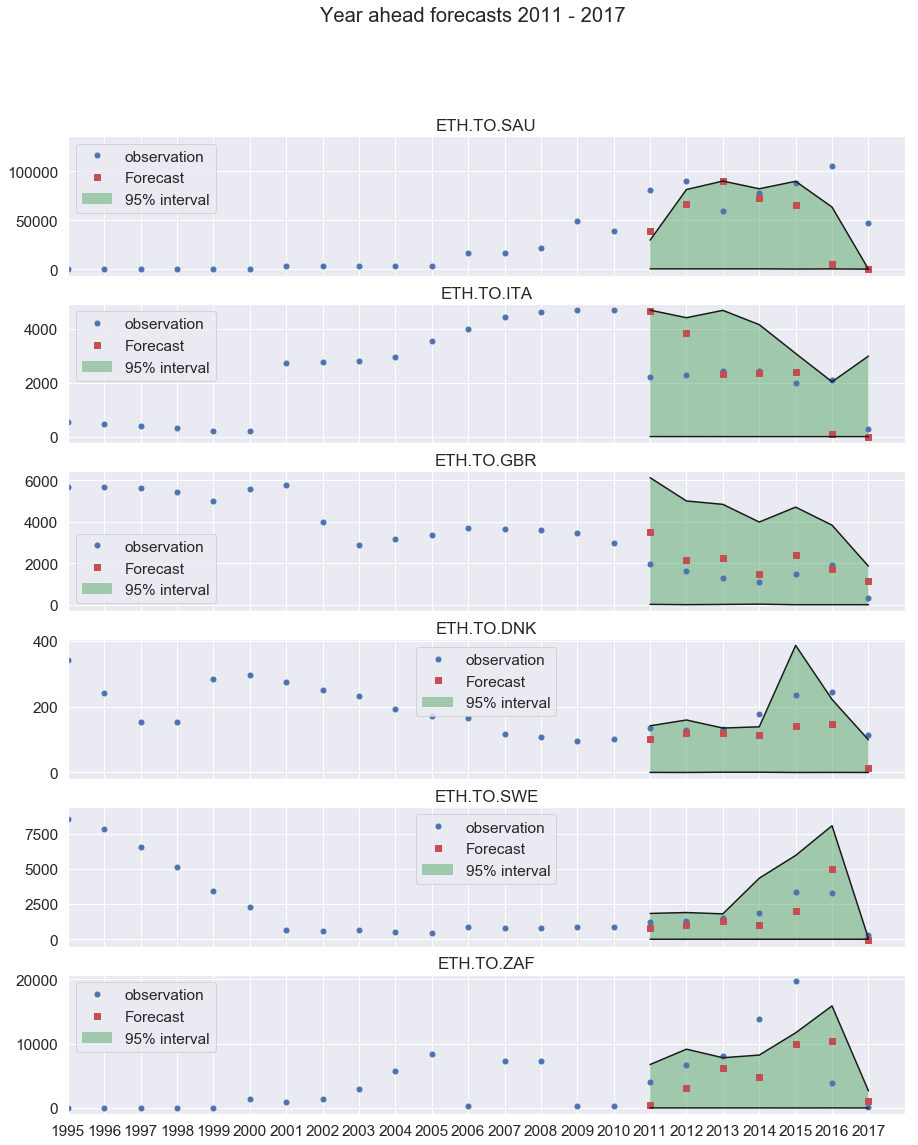

In [33]:

f, axarr = plt.subplots(len(TARGET_VARIABLES), figsize=(15, 18), sharex=True)

for i, target in enumerate(TARGET_VARIABLES):
    
    # Get the observations (from raw data)
    idx = (df['Indicator Code'] == target) & (df['Country Code'] == 'ETH')
    obs_x = df.loc[idx, 'year']
    obs_y = df.loc[idx, 'value']
    axarr[i].plot(obs_x, obs_y, 'b.', markersize=10, label='observation')
    
    # Get the forecast
    for_x = [k['period']['forecast_year'] for k in results if k['target'] == target]
    for_y = [k['forecast'][0] for k in results if k['target'] == target]
    ci_low_y = [k['CI'][0] for k in results if k['target'] == target]
    ci_hig_y = [k['CI'][1] for k in results if k['target'] == target]
    
    axarr[i].plot(for_x, for_y, 'rs', label=u'Forecast')
    axarr[i].plot(for_x, ci_hig_y, 'k-')
    axarr[i].plot(for_x, ci_low_y, 'k-')
    axarr[i].fill(np.concatenate([for_x, for_x[::-1]]),
         np.concatenate([ci_hig_y, ci_low_y[::-1]]),
         alpha=.5, fc='g', ec='None', label='95% interval')
    
    axarr[i].grid(True)
    axarr[i].legend(loc=0)
    plt.xlim([1995, 2018])
    plt.xticks(np.arange(1995, 2018, 1))
    axarr[i].set_title(target)
    plt.suptitle("Year ahead forecasts 2011 - 2017")
        
    
plt.savefig("Forecast-XGB.png", dpi=200, bbox_inches='tight')

# Model explanations

In [38]:
# Instance for which we should look explain
X_TARGET = 'ETH.TO.GBR'
X_YEAR = 2013

model = [k['model'] for k in results if (k['period']['forecast_year'] == X_YEAR) &
                                        (k['target'] == X_TARGET)][0]

_, _, Xv, _ = [k['data']['data'] for k in results if (k['period']['forecast_year'] == X_YEAR) &
                                        (k['target'] == X_TARGET)][0]
    


# compute the SHAP values for every prediction in the validation dataset
shap_values = shap.TreeExplainer(model).shap_values(Xv)
shap.force_plot(shap_values[0, :], Xv.iloc[0,:])

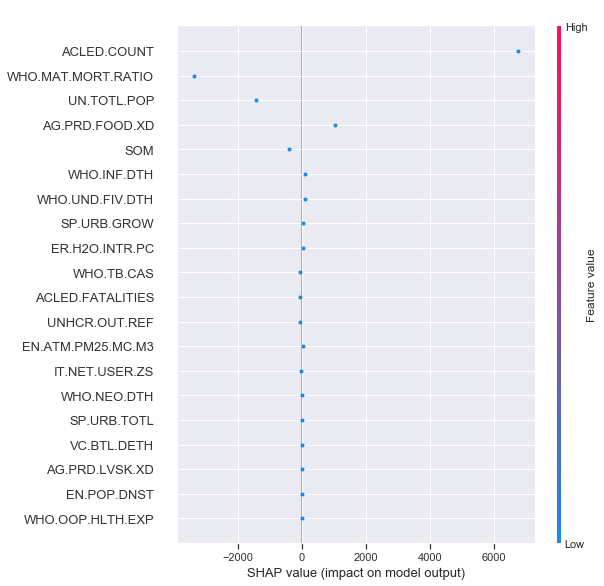

In [28]:
shap.summary_plot(shap_values, Xv)

# Misc.

In [34]:
mystr = """
name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
British Indian Ocean Territory,IO,IOT,086,ISO 3166-2:IO,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Burundi,BI,BDI,108,ISO 3166-2:BI,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Comoros,KM,COM,174,ISO 3166-2:KM,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Djibouti,DJ,DJI,262,ISO 3166-2:DJ,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Eritrea,ER,ERI,232,ISO 3166-2:ER,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Ethiopia,ET,ETH,231,ISO 3166-2:ET,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
French Southern Territories,TF,ATF,260,ISO 3166-2:TF,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Kenya,KE,KEN,404,ISO 3166-2:KE,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Madagascar,MG,MDG,450,ISO 3166-2:MG,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Malawi,MW,MWI,454,ISO 3166-2:MW,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Mauritius,MU,MUS,480,ISO 3166-2:MU,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Mayotte,YT,MYT,175,ISO 3166-2:YT,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Mozambique,MZ,MOZ,508,ISO 3166-2:MZ,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Réunion,RE,REU,638,ISO 3166-2:RE,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Rwanda,RW,RWA,646,ISO 3166-2:RW,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Seychelles,SC,SYC,690,ISO 3166-2:SC,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Somalia,SO,SOM,706,ISO 3166-2:SO,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
South Sudan,SS,SSD,728,ISO 3166-2:SS,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
"Tanzania, United Republic of",TZ,TZA,834,ISO 3166-2:TZ,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Uganda,UG,UGA,800,ISO 3166-2:UG,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014"""

from io import StringIO

tmp = pd.read_csv(StringIO(mystr))
tmp.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,British Indian Ocean Territory,IO,IOT,86,ISO 3166-2:IO,Africa,Sub-Saharan Africa,Eastern Africa,2,202,14
1,Burundi,BI,BDI,108,ISO 3166-2:BI,Africa,Sub-Saharan Africa,Eastern Africa,2,202,14
2,Comoros,KM,COM,174,ISO 3166-2:KM,Africa,Sub-Saharan Africa,Eastern Africa,2,202,14
3,Djibouti,DJ,DJI,262,ISO 3166-2:DJ,Africa,Sub-Saharan Africa,Eastern Africa,2,202,14
4,Eritrea,ER,ERI,232,ISO 3166-2:ER,Africa,Sub-Saharan Africa,Eastern Africa,2,202,14
